In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
%matplotlib inline

In [2]:
dfReset = pd.read_csv('../data/output/output.csv', parse_dates=['created_on'], infer_datetime_format=True)
dfPublished = dfReset[:]

In [3]:
dfPublished.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462286 entries, 0 to 1462285
Data columns (total 18 columns):
id                            1462286 non-null object
created_on                    1462286 non-null datetime64[ns]
property_type                 1462286 non-null object
place_name                    1462286 non-null object
state_name                    1462286 non-null object
lat                           1122304 non-null float64
lon                           1122293 non-null float64
price                         1462286 non-null float64
currency                      1457400 non-null object
price_aprox_local_currency    1462286 non-null float64
price_aprox_usd               1462286 non-null float64
surface_total_in_m2           1079918 non-null float64
surface_covered_in_m2         233333 non-null float64
price_usd_per_m2              1016393 non-null float64
price_per_m2                  226511 non-null float64
floor                         289280 non-null float64
rooms   

___
# Publicaciones VS Tiempo
___

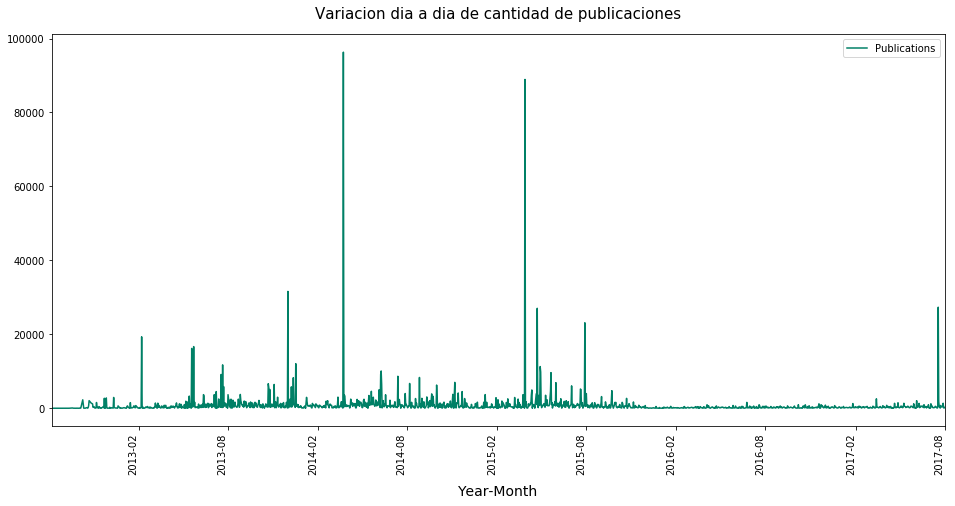

In [4]:
grouped = dfPublished[['created_on', 'id']].groupby(by='created_on').count().reset_index()
forPlot = grouped.rename(columns={'created_on':'Year-Month', 
                                  'id':'Publications'})
fig = forPlot.plot(x='Year-Month', 
                   figsize=(16, 8), 
                   colormap='summer', 
                   rot=90,
                   title="Variacion dia a dia de cantidad de publicaciones")
fig.xaxis.label.set_size(14)
fig.xaxis.set_label_coords(0.5, -0.15)
fig.title.set_size(15)
fig.title.set_position((0.5, 1.025));

In [5]:
forPlot.sort_values(by='Publications', ascending=False).head()

,Year-Month,Publications
511,2014-03-25,96315
873,2015-03-30,88937
401,2013-12-02,31604
1708,2017-07-19,27328
898,2015-04-24,27032


### ¿Que pasó en esas dos fechas que en un solo día hubo tantas ventas?
>**25 de Marzo de 2014:** Se buscaron noticias en Google filtrando por esa fecha acerca de bienes raíces y la situación económica del país para ver si se encontraba algún motivo que respaldara la enorme cantidad de publicaciones en un solo día. No se encontró nada lo suficientemente fuerte que explicara éste fenómeno. En el contexto mundial, fue la época en que se estaban vendiendo propiedades en Europa por precios extremadamente bajos debido a la crisis.<br>**30 de Marzo de 2015:** Se realizó la misma búsqueda sin un resultado que lo explique.

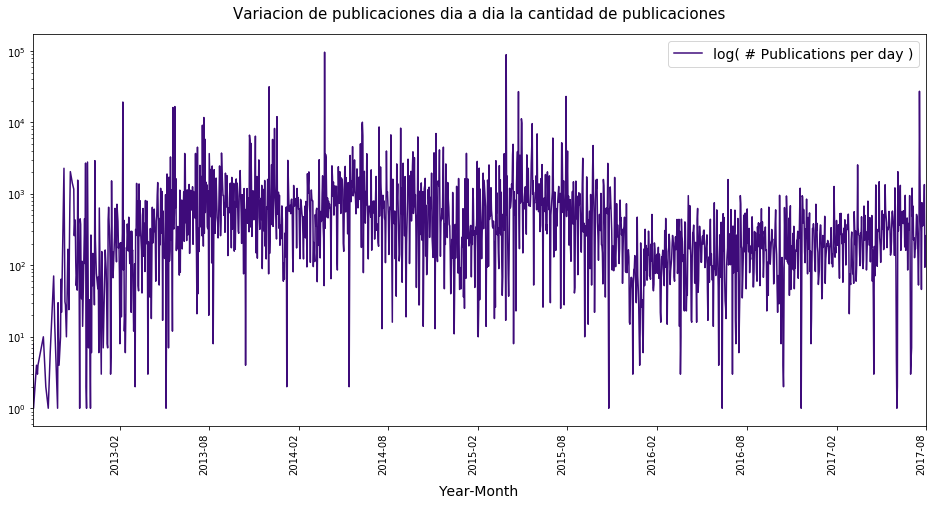

In [6]:
fig = forPlot.plot(x='Year-Month', 
                   figsize=(16, 8), 
                   color='#3e0b7a', 
                   logy=True, 
                   rot=90,
                   title="Variacion de publicaciones dia a dia la cantidad de publicaciones")
fig.xaxis.label.set_size(14)
fig.xaxis.set_label_coords(0.5, -0.15)
fig.title.set_size(15)
fig.legend(fontsize=14).get_texts()[0].set_text("log( # Publications per day )")
fig.title.set_position((0.5, 1.025));

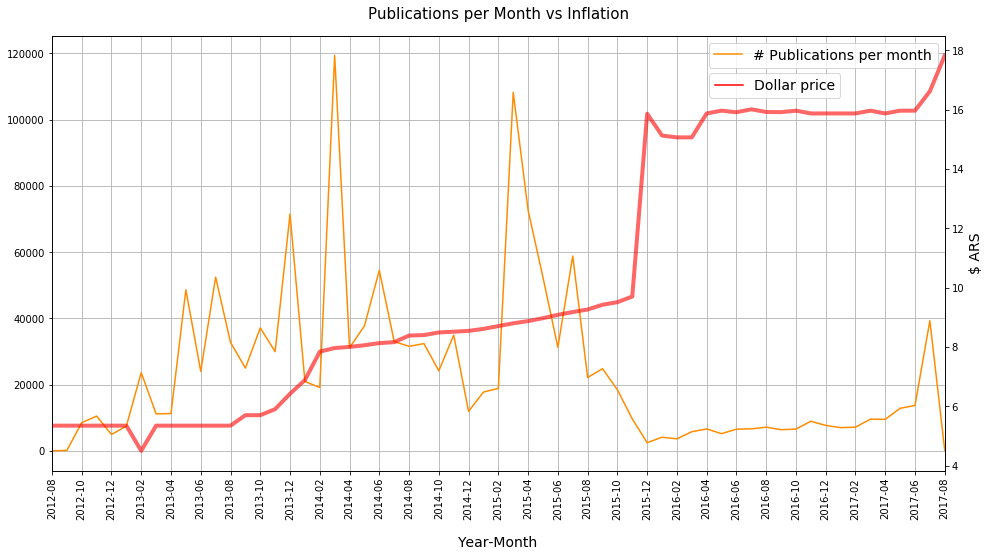

In [7]:
grouped = pd.DataFrame({'Year-Month':dfPublished.created_on.astype('str').str.slice(0, -3), 
                        'Publications':dfPublished.id})\
            .groupby(by='Year-Month')\
            .count()\
            .reset_index()

def getMonth(df, ind, col) :
    date = df.loc[ind, col]
    return str(date)[:7]

dfDollarPrice = dfPublished.loc[dfPublished.currency.str.contains('ARS', na=False) & 
                                (dfPublished.price_aprox_usd > 0)][['created_on', 'price', 'price_aprox_usd']]
dfDollarPrice = dfDollarPrice.groupby(lambda i: getMonth(dfDollarPrice, i, 'created_on'))\
                             .agg('first')    
dfDollarPrice['dollar_price'] = dfDollarPrice.apply(lambda row: row.price / row.price_aprox_usd, axis=1)
dfDollarPrice = dfDollarPrice.reset_index(drop='index')\
                             .loc[:, ('created_on', 'dollar_price')]    
dfDollarPrice.created_on = pd.Series(dfDollarPrice.created_on.astype('str').str.slice(0, -3))
dfDollarPrice.rename(columns={'created_on':'Year-Month'}, inplace=True)

grouped = grouped.merge(dfDollarPrice, how='inner', on='Year-Month')

ax = grouped.plot(x=grouped.loc[:, ('Year-Month')].astype('str'), 
                  kind='line',
                  figsize=(16, 8), 
                  xticks=range(0, len(grouped), 2), rot=90, 
                  secondary_y='dollar_price',
                  color=['DarkOrange', 'red'], 
                  title="Publications per Month vs Inflation")
ax.xaxis.label.set_size(14)
ax.xaxis.set_label_coords(0.5, -0.15)
ax.title.set_position((0.5, 1.025))
ax.title.set_size(15)
ax.grid(linestyle='solid')
ax.legend(fontsize=14).get_texts()[0].set_text("# Publications per month")
ax.right_ax.legend(fontsize=14).get_texts()[0].set_text("Dollar price")
legend = ax.right_ax.get_legend()
legend.set_bbox_to_anchor((0.891, 0.84))
ax.right_ax.get_lines()[0].set_alpha(0.6)
ax.right_ax.get_lines()[0].set_linewidth(4)
ax.right_ax.yaxis.label.set_size(14)
ax.right_ax.set_ylabel("$ ARS")
ax.set_axisbelow(True);

### Histórico de ventas vs precio del dólar:
> Podemos ver que existe una relación entre la cantidad de publicaciones de propiedades en venta que se realizan en un determinado mes con el precio del dólar.<br>El punto de inflexión más claro es a partir de **Diciembre del 2015**, donde el dólar se dispara y las publicaciones entran en un largo período de estancamiento. Ésta fecha coincide con la asunción del presidente Mauricio Macri, por lo que se puede suponer *(conociendo el contexto de la población)* que se generó una gran especulación acerca de ajustes por lo que la venta de una propiedad no sería tan viable como en el pasado.<br><br> Por otro lado no hay que dejar de notar un caso más aislado en **Febrero del 2013** donde si bien la reacción es mucho más pequeña, hay que considerar que el dólar disminuyó su precio a menos de la mitad dentro del mismo mes, dando lugar a otra posible especulación de buenas oportunidades para vender por parte de los dueños o inmobiliarias.

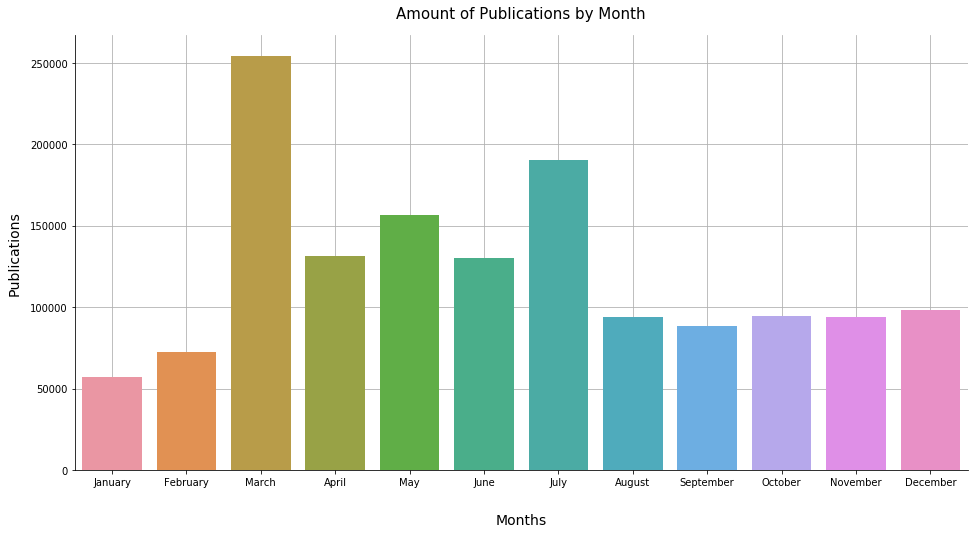

In [8]:
grouped = pd.DataFrame({'Months':pd.Series(dfPublished.created_on.dt.month), 'Publications':dfPublished.id})\
            .groupby(by='Months')\
            .count()
ax = sns.barplot(x='Months', y='Publications', data=grouped.reset_index())
ax.get_figure().set_size_inches(16,8)
ax.xaxis.set_ticklabels(calendar.month_name[1:])
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.yaxis.set_label_coords(-0.06, 0.5)
ax.xaxis.set_label_coords(0.5, -0.10)
ax.title.set_text('Amount of Publications by Month')
ax.title.set_position((0.5, 1.025))
ax.title.set_size(15)
ax.grid(linestyle='solid')
ax.set_axisbelow(True)
sns.despine();

### Histórico de publicaciones en buckets según mes
>Observamos que los meses con mayores ventas historicamente son **Marzo**, **Julio** y **Mayo**, mientras que desde Agosto hasta fin de las vacaciones de verano, la cantidad de publicaciones nuevas es mucho menor.

___
# Variables VS Precio
___

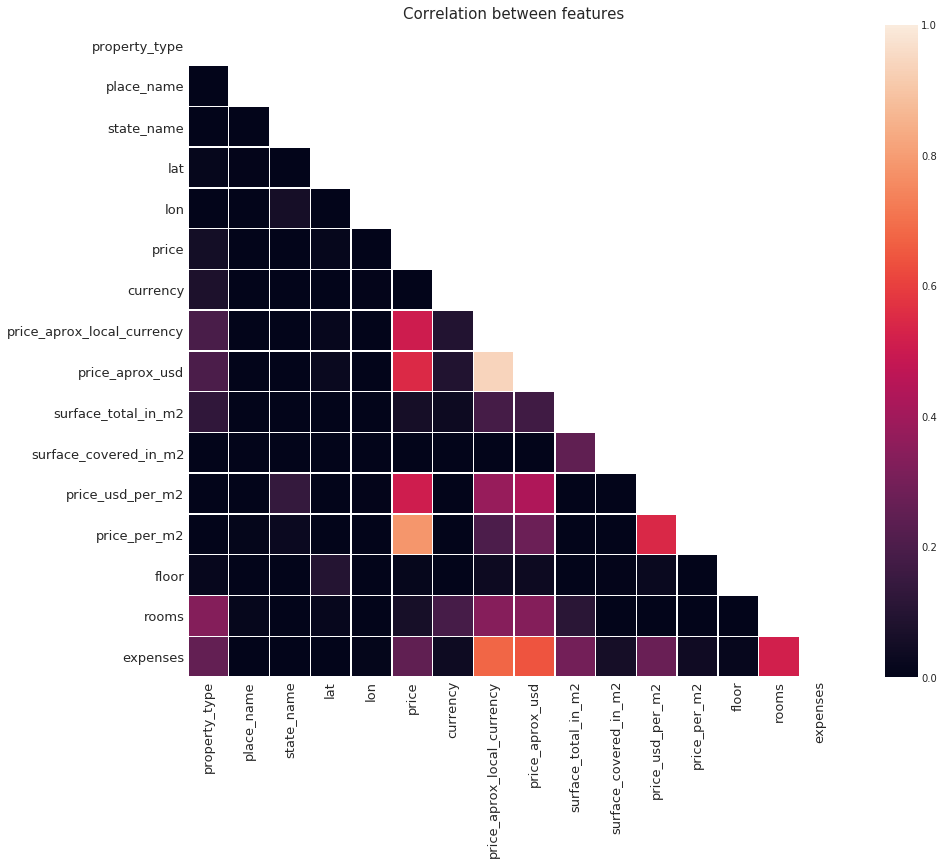

In [9]:
corr = dfPublished.fillna({'currency':'USD'})
dfPublished.currency = dfPublished.currency.astype('category')
dfPublished.currency = dfPublished.currency.cat.codes
dfPublished.state_name = dfPublished.state_name.astype('category')
dfPublished.state_name = dfPublished.state_name.cat.codes
dfPublished.place_name = dfPublished.place_name.astype('category')
dfPublished.place_name = dfPublished.place_name.cat.codes
dfPublished.property_type = dfPublished.property_type.astype('category')
dfPublished.property_type = dfPublished.property_type.cat.codes
corr = dfPublished.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmin=0.0, vmax=1.0, linewidths=.5, square=True)

ax.get_figure().set_size_inches(16,12)
ax.tick_params(labelsize=13)
ax.set_title("Correlation between features", fontdict={'size':15});

### Features con relaciones entre ellas
>Luego de tratar las columnas categóricas *(convertirlas a valores númericos)* para poder evaluar correlación entre ellas, se realiza un HeatMap que nos otorga un poco de información acerca de la naturaleza del set de datos.
Muchas columnas tienen relaciones obvias como la columna de precio en dólares y en pesos, por lo que vamos a quedarnos con un subset de este plot para una lectura más clara.

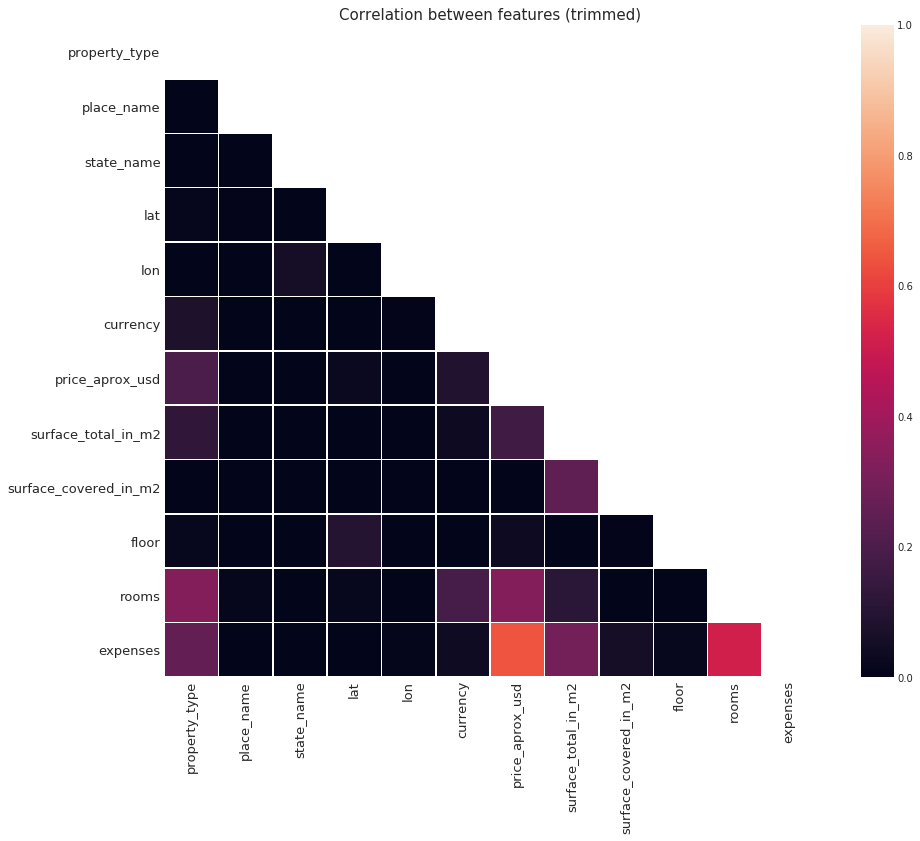

In [10]:
dfCorr = dfPublished.drop(['price', 'price_aprox_local_currency', 'price_per_m2', 'price_usd_per_m2'], axis=1)
dfCorr = dfCorr.fillna({'currency':'USD'})
dfCorr = dfCorr.corr()
mask = np.zeros_like(dfCorr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(dfCorr, mask=mask, vmin=0.0, vmax=1.0, linewidths=0.5, square=True)

ax.get_figure().set_size_inches(16,12)
ax.tick_params(labelsize=13)
ax.set_title("Correlation between features (trimmed)", fontdict={'size':15});


### Analizando el recorte
>La mayoría de las relaciones que se observan son bastante intuitivas, con excepción quizás de la relación entre la latitud y la cantidad de pisos de la propiedad. Otras que de antemano se pensó que seguro aparecian, no se hicieron presentes; como por ejemplo, la localidad con el precio de la propiedad.